In [1]:
### Calibrate camera
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from calibrate_cam import calibrate_camera
from get_perspective import get_perspective

# constants
ym_per_px = 3.7/700 # meters per pixel in y dimension
xm_per_px = 3.7/700 # meters per pixel in x dimension

nx = 9
ny = 6
calibration_images = sorted(glob.glob('./camera_cal/*.jpg'))
test_images = sorted(glob.glob('./test_images/*.jpg'))
img = cv2.imread('test_images/test5.jpg')
mtx, dist = calibrate_camera(calibration_images, nx, ny)


In [2]:
if not os.path.isdir('output_images\\undistorted'):
    os.mkdir('output_images\\undistorted')

if not os.path.isdir('output_images\\binary'):
    os.mkdir('output_images\\binary')

if not os.path.isdir('output_images\\perspective'):
    os.mkdir('output_images\\perspective')

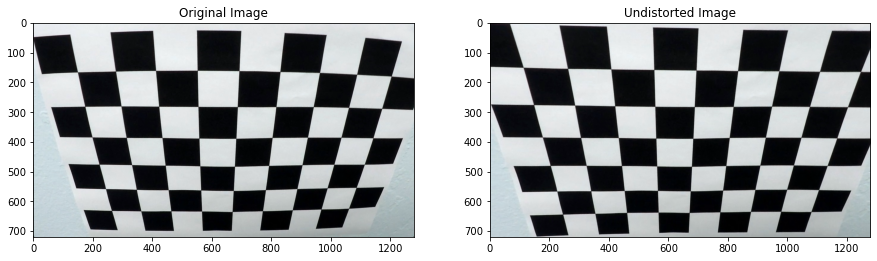

In [3]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L_channel = lab[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #Threshold LAB
    labbinary = np.zeros_like(L_channel)
    labbinary[(L_channel >= 100) & (L_channel <= 255)] = 1
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    img_bwa = cv2.bitwise_and(labbinary,s_binary)
    
    t_binary = np.zeros(img.shape[:2], dtype=np.uint8)
    t_binary[(L_channel >= 100) & (s_binary <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), np.zeros_like(sxbinary), img_bwa + sxbinary)) * 255
    return color_binary

### Undistort all the images
for filename in os.listdir("test_images"):
    image_dir = os.path.join('test_images', filename)
    image = cv2.imread(image_dir)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    undist_output = os.path.join('output_images\\undistorted', filename)
    cv2.imwrite(undist_output, undist)
    
    binary = pipeline(undist)
    binary_output = os.path.join('output_images\\binary', filename)
    cv2.imwrite(binary_output, binary)
    
    perspec, M, Minv = get_perspective(binary)
    gray = cv2.cvtColor(perspec, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    perspec_output = os.path.join('output_images\\perspective', filename)
    cv2.imwrite(perspec_output, blackAndWhiteImage)

orig = cv2.imread('camera_cal/calibration2.jpg')
und = cv2.undistort(orig, mtx, dist, None, mtx)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(orig)
ax1.set_title("Original Image")
ax2.imshow(und)
ax2.set_title("Undistorted Image")
plt.savefig('output_images/undistorted.jpg', bbox_inches='tight')

In [4]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def compute_lane_curvature(leftx, rightx, ploty, cols, y0):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        # Define conversions in x and y from pixels space to meters
        y_eval = np.max(ploty)
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * ym_per_px, leftx * xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_px, rightx * xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        left = np.polyval(left_fit_cr, y0*ym_per_px)
        right = np.polyval(right_fit_cr, y0*ym_per_px)
        center = cols / 2 * xm_per_px
        offcenter = center - (left + right)/2
        curverad = (left_curverad + right_curverad) / 2
        # Now our radius of curvature is in meters        
        return curverad, offcenter

    
def search_around_poly(binary_warped, Minv, left_fit, right_fit, undist):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    rows, cols = undist.shape[:2]
    y0 = rows-1
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    curverad, offcenter = compute_lane_curvature(left_fitx, right_fitx, ploty, cols, y0)
    
    
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    return result, curverad, offcenter

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = pipeline(undist)
    
    perspec, M, Minv = get_perspective(binary)
    gray = cv2.cvtColor(perspec, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    out_img, left_fit, right_fit = fit_polynomial(blackAndWhiteImage)
    result, curverad, offcenter = search_around_poly(blackAndWhiteImage, Minv, left_fit, right_fit, undist)
    img = cv2.putText(result, 'Radius of curvature:', (20,60), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, '{0:>10.3f} m'.format(curverad), (700,60), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, 'Distance from lane center:', (20,130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    img = cv2.putText(result, '{0:>+10.3f} m'.format(offcenter), (700,130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), 10, cv2.LINE_AA)
    return result

In [7]:
white_output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 3min 43s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [28]:
chal_output = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
chal_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time chal_clip.write_videofile(chal_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]


67.46525879239577 112.09183844485797
Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4

67.46525879239577 112.09183844485797


t:   1%|          | 4/485 [00:00<00:54,  8.91it/s, now=None]

99.52016874341187 84.42617318336734
61.76495953818627 104.34372745453706



t:   1%|          | 5/485 [00:00<01:00,  7.99it/s, now=None]

59.96527252541918 123.26347486736833
43.32456317518724 144.40109735452756



t:   2%|▏         | 8/485 [00:01<01:06,  7.13it/s, now=None]

37.027503205193845 140.72207840764247
43.05799498267148 131.38347963915956



t:   2%|▏         | 10/485 [00:01<01:09,  6.86it/s, now=None]

45.89293119887958 141.9529165475105
38.863674797011306 141.71227458768084



t:   2%|▏         | 11/485 [00:01<01:11,  6.60it/s, now=None]

32.17720882007229 117.59244435474214
29.866253794799082 90.50654384409765



t:   3%|▎         | 13/485 [00:01<01:17,  6.08it/s, now=None]

25.705105563006484 94.504696349916
46.76115832294776


t:   3%|▎         | 15/485 [00:02<01:17,  6.10it/s, now=None]

 108.41620880957342
63.63422161315247 94.27944661702145



t:   3%|▎         | 16/485 [00:02<01:17,  6.08it/s, now=None]

39.79623144818665 113.92755039192427
65.61832360142432 90.22236876865271



t:   4%|▍         | 19/485 [00:02<01:13,  6.36it/s, now=None]

50.76914145304739 90.2718902651632
48.208591790538556 335.9366059239754



t:   4%|▍         | 20/485 [00:03<01:15,  6.14it/s, now=None]

15.881785450452504 94.80758792097191
113.17895801158191 315.35740832297375



t:   5%|▍         | 22/485 [00:03<01:16,  6.06it/s, now=None]

162.77508112755544 738.3879498429142
22.348765617644236 59.19193829185498



t:   5%|▍         | 24/485 [00:03<01:16,  6.00it/s, now=None]

39.66507911851303 56.773883519637494
22.384233613540157 260.13291965178445



t:   5%|▌         | 26/485 [00:04<01:17,  5.96it/s, now=None]

75.87229968408948 50.581378188967356
35.69422811651797


t:   6%|▌         | 27/485 [00:04<01:18,  5.81it/s, now=None]

 39.931502926855636
492.51254934855695 


t:   6%|▌         | 28/485 [00:04<01:21,  5.59it/s, now=None]

150.05770622491778
64.1897175471871


t:   6%|▌         | 29/485 [00:04<01:22,  5.55it/s, now=None]

 47.28509215718856
52.73532352087595 1938.457821166326



t:   6%|▋         | 31/485 [00:04<01:19,  5.69it/s, now=None]

48.85684592048018 43.46899102989792



t:   7%|▋         | 32/485 [00:05<01:23,  5.41it/s, now=None]

54.925439761155076 352.4372279053329
42.37858202845932


t:   7%|▋         | 33/485 [00:05<01:24,  5.37it/s, now=None]

 658.846564924155
56.399008923305324


t:   7%|▋         | 34/485 [00:05<01:24,  5.32it/s, now=None]

 169.9740163498526
183.80064824801534


t:   7%|▋         | 35/485 [00:05<01:26,  5.20it/s, now=None]

 97.30888227829456
81.88901900578963


t:   7%|▋         | 36/485 [00:05<01:27,  5.14it/s, now=None]

 92.87053069690744
83.17839544188556


t:   8%|▊         | 37/485 [00:06<01:26,  5.18it/s, now=None]

 29.146142199871434
37.401575812282566


t:   8%|▊         | 38/485 [00:06<01:26,  5.16it/s, now=None]

 21.21080024280664
144.5268498780384


t:   8%|▊         | 39/485 [00:06<01:26,  5.18it/s, now=None]

 22.737799827342716



t:   8%|▊         | 40/485 [00:06<01:26,  5.12it/s, now=None]

117.77466272831417 27.89983867941343
32.791531305640206


t:   8%|▊         | 41/485 [00:06<01:26,  5.10it/s, now=None]

 36.235077378625896



t:   9%|▊         | 42/485 [00:07<01:30,  4.91it/s, now=None]

180.41562382298167 85.00168956682188
107.86690523701621 


t:   9%|▉         | 43/485 [00:07<01:27,  5.08it/s, now=None]

121.99523318895189
91.85901349386542


t:   9%|▉         | 44/485 [00:07<01:26,  5.12it/s, now=None]

 77.38764564227975
116.3333511362756 105.64338108182274



t:   9%|▉         | 46/485 [00:07<01:21,  5.40it/s, now=None]

389.4139158793087 121.36437466809707
776.1235755567861


t:  10%|▉         | 47/485 [00:08<01:21,  5.39it/s, now=None]

 57.70163675847747
67.26454975112998


t:  10%|▉         | 48/485 [00:08<01:20,  5.40it/s, now=None]

 177.9913834728304
129.75925318475805


t:  10%|█         | 49/485 [00:08<01:21,  5.32it/s, now=None]

 364.8200272455445
125.0999275531694 231.19479983855166



t:  11%|█         | 52/485 [00:08<01:11,  6.03it/s, now=None]

80.81833392863403 46.6113488346693
121.01667421568068 38.30522369332057



t:  11%|█         | 54/485 [00:09<01:08,  6.25it/s, now=None]

141.50548700396158 40.96128135082158
507.56183207477056 38.579333915220786



t:  12%|█▏        | 56/485 [00:09<01:06,  6.41it/s, now=None]

245.05890148278777 41.55653949292571
168.69321569423596 42.956892018338834



t:  12%|█▏        | 58/485 [00:09<01:05,  6.53it/s, now=None]

144.29071835869053 45.42694342485307
178.98104188738657 45.112963529406336



t:  12%|█▏        | 60/485 [00:10<01:04,  6.62it/s, now=None]

801.0901059851068 47.927757558888324
40.55789886503509 48.97677115199796



t:  13%|█▎        | 62/485 [00:10<01:04,  6.56it/s, now=None]

39.22379060634412 48.67907145095029
120.67168153138617 46.720570410438626



t:  13%|█▎        | 64/485 [00:10<01:03,  6.60it/s, now=None]

74.38204267606773 31.033737627892567
68.686636232957 2390.213073143532



t:  14%|█▎        | 66/485 [00:10<01:04,  6.54it/s, now=None]

123.66213212549525 45.20802079982704
203.1562782312551 46.82277397809661



t:  14%|█▍        | 68/485 [00:11<01:01,  6.77it/s, now=None]

185.65182792516975 46.601465234873785
46.312600017814795 44.74839815345119



t:  14%|█▍        | 70/485 [00:11<01:01,  6.77it/s, now=None]

51.20866155007341 47.24279412267303
131.50452747536505 44.71469530641582



t:  15%|█▍        | 72/485 [00:11<01:01,  6.67it/s, now=None]

113.5785170279373 48.16772949076705
144.45700301497766 48.89747292623919



t:  15%|█▌        | 74/485 [00:12<01:01,  6.66it/s, now=None]

155.35416768022353 57.465801563370164
126.10556520197716 59.35297079411476



t:  16%|█▌        | 76/485 [00:12<01:01,  6.65it/s, now=None]

135.1018971015745 59.098793029755676
92.50563787056473 65.08814038401735



t:  16%|█▌        | 77/485 [00:12<01:00,  6.76it/s, now=None]

128.12933671684854 67.28527071436336
130.76176379385245 69.99748792302388



t:  16%|█▋        | 80/485 [00:13<01:00,  6.66it/s, now=None]

127.93747517586243 68.65097475832238
118.50173146821524 63.97447701552032



t:  17%|█▋        | 81/485 [00:13<01:00,  6.69it/s, now=None]

69.96261019397348 66.3998990606194
63.1452637138398 61.45050298738677



t:  17%|█▋        | 84/485 [00:13<01:00,  6.59it/s, now=None]

83.77223615768091 70.15131148911225
146.61298246729064 73.10437292407453



t:  18%|█▊        | 86/485 [00:14<01:02,  6.41it/s, now=None]

154.64606099648267 71.13516758869004
116.41675564201466 73.11382169764315



t:  18%|█▊        | 88/485 [00:14<01:01,  6.50it/s, now=None]

151.1583963502853 75.69697134730988
154.87794289473436 74.73885798884638



t:  18%|█▊        | 89/485 [00:14<01:01,  6.47it/s, now=None]

146.33980850074227 72.69418183036106
129.7626497338889 73.50643600640788



t:  19%|█▉        | 92/485 [00:14<01:01,  6.41it/s, now=None]

94.21129019021554 75.62862746244578
167.10242395544688 73.65184807327806



t:  19%|█▉        | 94/485 [00:15<00:59,  6.53it/s, now=None]

153.67076173790502 74.1707416290547
152.11124013328666 81.06758073807505



t:  20%|█▉        | 96/485 [00:15<01:00,  6.48it/s, now=None]

141.70423013088765 84.63516212480714
132.3213756485777 71.385657181077



t:  20%|██        | 98/485 [00:15<00:58,  6.63it/s, now=None]

172.99907151549257 520.7754529384514
170.1448633197282 813.8139551762355



t:  21%|██        | 100/485 [00:16<00:58,  6.62it/s, now=None]

231.57815557423214 74.97717501833102
81.21779419730042 100.0422129196622



t:  21%|██        | 102/485 [00:16<00:57,  6.63it/s, now=None]

66.45268803058461 80.15968897143468
45.567600000951856 288.0621029188048



t:  21%|██        | 103/485 [00:16<00:58,  6.53it/s, now=None]

45.20357470663456 535.9436457705746
51.640135332030134 102.7168776527854



t:  22%|██▏       | 106/485 [00:17<00:57,  6.62it/s, now=None]

46.340935914873604 75.24075831558581
57.74835170957654 99.5950202058473



t:  22%|██▏       | 108/485 [00:17<00:57,  6.59it/s, now=None]

39.894558384394685 122.30293145164556
55.651550970223184 90.06705024671423



t:  23%|██▎       | 110/485 [00:17<00:56,  6.62it/s, now=None]

42.960047426396265 113.99060071911335
49.646211905822014 106.23595864594625



t:  23%|██▎       | 112/485 [00:17<00:56,  6.56it/s, now=None]

48.6888653777281 291.5538810676696
31.291628617423907 280.0080300732402



t:  24%|██▎       | 114/485 [00:18<00:54,  6.85it/s, now=None]

27.644876712371317 114.88404506705213
26.653621001850556 109.69964946069103



t:  24%|██▍       | 116/485 [00:18<00:54,  6.82it/s, now=None]

45.07813467184031 100.0212635702668
30.70559938764447 107.23873842518316



t:  24%|██▍       | 118/485 [00:18<00:54,  6.70it/s, now=None]

33.310023168468376 119.59302021295088
28.953520014141677 102.71058391268271



t:  25%|██▍       | 120/485 [00:19<00:54,  6.67it/s, now=None]

19.73428940712572 93.46104281856081
539.8368697540567 84.99901609996247



t:  25%|██▌       | 122/485 [00:19<00:55,  6.51it/s, now=None]

336.14519465212356 82.75475089399026
203.61522833565292 70.26708714211811



t:  26%|██▌       | 124/485 [00:19<00:55,  6.45it/s, now=None]

187.6117961504569 70.01999391549418
193.93144486740852 78.56132117962643



t:  26%|██▌       | 126/485 [00:20<00:55,  6.48it/s, now=None]

117.75444539140992 76.69843962170673
27.14599282583904 77.1438176284831



t:  26%|██▋       | 128/485 [00:20<00:53,  6.70it/s, now=None]

16.118420936690004 85.03614835625338
11.131204244047419 87.17632939629038



t:  27%|██▋       | 130/485 [00:20<00:52,  6.71it/s, now=None]

7.085633142194373 90.93204148155102
3.6135284157102587 91.25347335242384



t:  27%|██▋       | 132/485 [00:20<00:52,  6.71it/s, now=None]

2.7694934037537293 89.58900579820627
8.69889849688659 86.02341610469561



t:  28%|██▊       | 134/485 [00:21<00:51,  6.83it/s, now=None]

0.5776099246830019 80.0139806061736
4947.366748724651 54.12941893631682



t:  28%|██▊       | 136/485 [00:21<00:52,  6.69it/s, now=None]

373.41470592622335 74.05112843093804
1302.639304193627 93.62881528778378



t:  28%|██▊       | 138/485 [00:21<00:53,  6.55it/s, now=None]

624.9338182503757 81.14705354661346
535.4107516059543 88.25375099891043



t:  29%|██▊       | 139/485 [00:22<00:52,  6.57it/s, now=None]

575.5000612823984 76.78013963815003
390.4224588636901 84.73455825109332



t:  29%|██▉       | 142/485 [00:22<00:53,  6.37it/s, now=None]

1461.7509814348914 78.37766020674489
2512.822296946693 72.56784135547416



t:  30%|██▉       | 144/485 [00:22<00:51,  6.56it/s, now=None]

909.0492147539396 66.14336239124266
254.65571103977396 65.54986820700994



t:  30%|███       | 146/485 [00:23<00:51,  6.57it/s, now=None]

409.25637051068867 69.11228614718783
328.04058794807287 70.80296344998256



t:  30%|███       | 147/485 [00:23<00:51,  6.61it/s, now=None]

729.3363113624769 78.28692470071465
998.3407733840287 81.54027195417724



t:  31%|███       | 150/485 [00:23<00:52,  6.37it/s, now=None]

624.6306676389256 83.12434431650638
487.20702799189627 81.13587624113279



t:  31%|███       | 151/485 [00:23<00:52,  6.41it/s, now=None]


504.8352009679714 88.21703217449239
232.48823203998265 81.1143027107654


t:  32%|███▏      | 153/485 [00:24<00:52,  6.29it/s, now=None]

245.80577266963306 89.15825739162113
214.24547130649728 84.05605408330963



t:  32%|███▏      | 156/485 [00:24<00:52,  6.28it/s, now=None]

231.68026900209554 88.73143573233197
243.2958439269059 92.13720593371393



t:  32%|███▏      | 157/485 [00:24<00:52,  6.26it/s, now=None]


230.58615611890028 94.06619201674566
229.3405307620989 95.71685048390172


t:  33%|███▎      | 159/485 [00:25<00:52,  6.26it/s, now=None]


151.30997468087668 92.7040568457873
144.45675011366905 92.77188561780669


t:  33%|███▎      | 161/485 [00:25<00:52,  6.22it/s, now=None]

130.64276199638732 78.78725819731766
123.45013217964781 81.23057493495754



t:  34%|███▍      | 164/485 [00:25<00:51,  6.25it/s, now=None]

121.94461360025888 71.13057313298843
125.28306065947558 80.88587241490163



t:  34%|███▍      | 165/485 [00:26<00:50,  6.28it/s, now=None]

137.68801947011818 91.08096781001899
117.14067646689115 79.91450112839094



t:  34%|███▍      | 167/485 [00:26<00:50,  6.35it/s, now=None]

117.68363348137501 80.07389205880433
125.72973129561771 88.87943017575462



t:  35%|███▌      | 170/485 [00:26<00:48,  6.54it/s, now=None]

124.17568390290926 92.2561099168062
109.75935143677765 93.56395025074238



t:  35%|███▌      | 172/485 [00:27<00:47,  6.57it/s, now=None]

102.89380139871933 92.05674687329962
102.06219009676961 95.36178586439155



t:  36%|███▌      | 173/485 [00:27<00:47,  6.57it/s, now=None]


99.91089423641026 97.47587299283066
97.41863434802305 100.12138993295851


t:  36%|███▋      | 176/485 [00:27<00:47,  6.49it/s, now=None]

95.50696732448262 105.03558855271052
96.07855596835043 103.03350029731904



t:  37%|███▋      | 178/485 [00:28<00:46,  6.66it/s, now=None]

94.45209766073047 114.03041594549913
94.52148183167715 113.94406601575163



t:  37%|███▋      | 179/485 [00:28<00:46,  6.61it/s, now=None]


91.4528241402651 109.14187755422104
91.70450707471348 102.8363535864883


t:  38%|███▊      | 182/485 [00:28<00:45,  6.61it/s, now=None]

103.35273991961625 103.68583528218349
105.52374224670433 110.73236447458787



t:  38%|███▊      | 184/485 [00:29<00:45,  6.55it/s, now=None]

101.48443395697615 111.2896826612767
90.55726946678142 116.09760122263485



t:  38%|███▊      | 186/485 [00:29<00:47,  6.34it/s, now=None]

103.93015268373819 123.9961436897766
90.82614959856282 126.32890416981436



t:  39%|███▉      | 188/485 [00:29<00:45,  6.48it/s, now=None]

85.99489488719317 110.91623635604816
84.37079167460931 75.87942280637881



t:  39%|███▉      | 189/485 [00:29<00:45,  6.50it/s, now=None]

89.31866815420895 164.54480281348648
87.69622682391137 126.97485488613141



t:  40%|███▉      | 192/485 [00:30<00:45,  6.47it/s, now=None]

104.68619841570903 85.35408221967168
135.8541709706209 93.3961521730424



t:  40%|████      | 194/485 [00:30<00:43,  6.63it/s, now=None]

142.49856526217326 92.09417448486751
138.86468122040083 83.02609771586347



t:  40%|████      | 196/485 [00:30<00:43,  6.69it/s, now=None]

90.98493837420448 86.61325713150102
167.5698156916391 93.99146973274159



t:  41%|████      | 198/485 [00:31<00:42,  6.79it/s, now=None]

176.0803694790498 91.90996992361862
86.18875294076268 77.55165750001257



t:  41%|████      | 199/485 [00:31<00:41,  6.82it/s, now=None]

81.60199010855276 82.71151153331937
87.99883107971334 86.07042277324588



t:  42%|████▏     | 202/485 [00:31<00:42,  6.59it/s, now=None]

90.1657149798367 81.61588975742401
82.19665159816624 65.03805173952385



t:  42%|████▏     | 204/485 [00:32<00:41,  6.69it/s, now=None]

93.69161440426718 67.80737311585229
86.18625336158013 72.71961241363016



t:  42%|████▏     | 205/485 [00:32<00:42,  6.60it/s, now=None]

73.0168640205717 77.20390624905052
71.01628976736501 83.60908423080734



t:  43%|████▎     | 208/485 [00:32<00:41,  6.71it/s, now=None]

118.97262996314964 62.17279126612821
76.20245157446607 73.22056758822195



t:  43%|████▎     | 210/485 [00:33<00:42,  6.54it/s, now=None]

74.03205186977871 70.95565202269377
82.72057376288441 83.685798440799



t:  44%|████▎     | 212/485 [00:33<00:41,  6.54it/s, now=None]

77.84168834469168 86.23859500739658
95.84183508014047 82.77704035085486



t:  44%|████▍     | 214/485 [00:33<00:40,  6.70it/s, now=None]

90.88470924004896 82.63259386457263
86.0253090965578 86.96710217536821



t:  45%|████▍     | 216/485 [00:33<00:40,  6.57it/s, now=None]

82.66491592224659 72.35400048996274
75.63678262388896 85.83689457155667



t:  45%|████▍     | 218/485 [00:34<00:40,  6.66it/s, now=None]

84.4833999982837 80.89061987358235
84.17261373382672 83.29454076608285



t:  45%|████▌     | 220/485 [00:34<00:38,  6.81it/s, now=None]

84.75648203907843 80.60062414508715
87.3058205920146 78.82168144177902



t:  46%|████▌     | 222/485 [00:34<00:38,  6.74it/s, now=None]

86.48340731530666 77.98705480239614
92.24629908356849 93.0064385993694



t:  46%|████▌     | 224/485 [00:35<00:38,  6.75it/s, now=None]

92.94327111940012 96.30479379657248
93.9589163272521 91.34712414563494



t:  47%|████▋     | 226/485 [00:35<00:39,  6.58it/s, now=None]

86.68985573010022 97.52583414495659
85.85040959999807 88.7390785123661



t:  47%|████▋     | 228/485 [00:35<00:38,  6.60it/s, now=None]

83.20354759460419 88.7050135192841
85.28668840704297 89.88797422918313



t:  47%|████▋     | 230/485 [00:35<00:38,  6.66it/s, now=None]

85.34172430509456 86.6925981864133
87.70753936790182 92.76279715564515



t:  48%|████▊     | 232/485 [00:36<00:37,  6.80it/s, now=None]

90.85795449405369 101.49538469919958
94.38355669905765 88.30073059495926



t:  48%|████▊     | 234/485 [00:36<00:37,  6.67it/s, now=None]

100.48577595958804 102.88126053805473
103.52769789996378 91.44878853454713



t:  49%|████▊     | 236/485 [00:36<00:37,  6.72it/s, now=None]

111.0603653983228 88.67172344004409
122.98986184254953 77.98500409554828



t:  49%|████▉     | 238/485 [00:37<00:36,  6.83it/s, now=None]

134.73047470636968 95.32529658617506
111.86300307377245 84.89449694739739



t:  49%|████▉     | 240/485 [00:37<00:36,  6.65it/s, now=None]

133.04029134396495 81.42374245709908
165.4636913414006 80.60306209844877



t:  50%|████▉     | 242/485 [00:37<00:35,  6.81it/s, now=None]

79.1568487581246 101.30252603072132
92.92825822264109 93.7814777524019



t:  50%|█████     | 244/485 [00:38<00:36,  6.58it/s, now=None]

112.50297535853404 67.61201081958126
113.96838011073116 70.6289600187453



t:  51%|█████     | 246/485 [00:38<00:35,  6.77it/s, now=None]

107.8181218282145 77.34915968591227
299.1903615150859 86.21703317803957



t:  51%|█████     | 248/485 [00:38<00:35,  6.68it/s, now=None]

206.15359666023795 84.24823518913551
86.96095108988833 77.57548136667008



t:  52%|█████▏    | 250/485 [00:38<00:36,  6.49it/s, now=None]

376.2873707473648 90.65480831101407
90.41092485389014 93.88082083047465



t:  52%|█████▏    | 252/485 [00:39<00:34,  6.67it/s, now=None]

233.64634421330737 102.43757270913055
54.27443923189699 93.72779894762319



t:  52%|█████▏    | 254/485 [00:39<00:34,  6.64it/s, now=None]

168.4359242640578 91.74779261099715
62.073596251667695 96.08219533168432



t:  53%|█████▎    | 256/485 [00:39<00:34,  6.63it/s, now=None]

58.66217441673028 92.48778863098433
66.89399326577428 95.15355487493893



t:  53%|█████▎    | 258/485 [00:40<00:32,  6.97it/s, now=None]

76.22558225156668 76.22293789489837
62.60261557114596 81.76199223063833



t:  53%|█████▎    | 259/485 [00:40<00:33,  6.78it/s, now=None]

68.6221381053043 88.48603595591064
59.804449958243175 82.75235830623119



t:  54%|█████▍    | 262/485 [00:40<00:33,  6.73it/s, now=None]

56.73197958609842 849.8293995510353
61.542306563830564 69.72428451254719



t:  54%|█████▍    | 264/485 [00:41<00:32,  6.71it/s, now=None]

59.18326380049434 69.32656865206883
61.4699281294 76.56478166709107



t:  55%|█████▍    | 266/485 [00:41<00:32,  6.82it/s, now=None]

58.0960010693597 83.45890129695704
69.63884675987292 85.36562728404004



t:  55%|█████▌    | 268/485 [00:41<00:32,  6.67it/s, now=None]

66.05441171643628 83.51057932951846
62.64776339718245 541.5256224237573



t:  56%|█████▌    | 270/485 [00:41<00:31,  6.74it/s, now=None]

66.006151335339 1084.128755358202
70.20425212758575 109.18126547958528



t:  56%|█████▌    | 272/485 [00:42<00:31,  6.69it/s, now=None]

71.6971554892377 61.86869833172279
71.82614655567849 96.50703641784061



t:  56%|█████▋    | 274/485 [00:42<00:32,  6.55it/s, now=None]

70.03919668242935 79.27747903897738
71.56480748446374 91.23130929642178



t:  57%|█████▋    | 276/485 [00:42<00:31,  6.55it/s, now=None]

69.01895805770585 73.55606135959907
71.40363876655414 376.5002379161832



t:  57%|█████▋    | 277/485 [00:43<00:31,  6.57it/s, now=None]

70.88791975460708 371.1179073928163
71.56868742260993 269.9141258171515



t:  58%|█████▊    | 279/485 [00:43<00:34,  5.97it/s, now=None]

59.78313220507873 169.4442964885327
243.1194886854261 95.09139747725484



t:  58%|█████▊    | 282/485 [00:43<00:33,  6.05it/s, now=None]

57.02817985944771 132.01662506490078
76.49031080332465 183.8969108624983



t:  59%|█████▊    | 284/485 [00:44<00:31,  6.41it/s, now=None]

83.08354901324553 4103.8293426180835
92.05384155865771 237.50364325130877



t:  59%|█████▉    | 286/485 [00:44<00:31,  6.42it/s, now=None]

96.55585764669253 161.87117305162428
99.83081191728695 2338.94214009559



t:  59%|█████▉    | 288/485 [00:44<00:30,  6.51it/s, now=None]

108.13061229433926 84.24833673350327
112.54797425512051 89.78774852553235



t:  60%|█████▉    | 289/485 [00:44<00:30,  6.45it/s, now=None]

114.37219251853926 103.4861249496225
114.57801477407146 95.2837263863713



t:  60%|██████    | 292/485 [00:45<00:29,  6.46it/s, now=None]

116.6709894053326 112.63064250073069
118.66116809004677 91.46682621149408



t:  61%|██████    | 294/485 [00:45<00:29,  6.50it/s, now=None]

122.05547644274465 184.99308814934435
134.8728450435634 210.1481374468565



t:  61%|██████    | 296/485 [00:46<00:28,  6.61it/s, now=None]

139.39678273799987 1394.7059159965786
143.35020236877818 102.97872732205094



t:  61%|██████    | 297/485 [00:46<00:28,  6.61it/s, now=None]

154.71984026815943 109.05758584661979
171.03378059151345


t:  61%|██████▏   | 298/485 [00:46<00:30,  6.09it/s, now=None]


 100.65780729527883
173.59106794060924 103.68827009193944


t:  62%|██████▏   | 301/485 [00:46<00:29,  6.33it/s, now=None]

184.80260356701748 123.15379100513229
193.98983762336331 134.21795883115493



t:  62%|██████▏   | 303/485 [00:47<00:28,  6.36it/s, now=None]

193.27957066006277 135.5449092460067
201.15031061736138 126.24725021853699



t:  63%|██████▎   | 305/485 [00:47<00:27,  6.47it/s, now=None]

200.62549652664055 137.86080433563902
215.63580444368856 106.30539010656975



t:  63%|██████▎   | 307/485 [00:47<00:27,  6.49it/s, now=None]

221.53153734637067 128.40202685726675
244.36049432102155 137.54831431734982



t:  64%|██████▎   | 309/485 [00:48<00:26,  6.53it/s, now=None]

277.8308061846 134.1720948509552
286.4234595818765 151.8830747019714



t:  64%|██████▍   | 311/485 [00:48<00:26,  6.53it/s, now=None]

291.85501126294315 121.52094953694346
307.2295102268489 84.22705046977848



t:  65%|██████▍   | 313/485 [00:48<00:26,  6.49it/s, now=None]

297.9483135783013 178.74713862908504
323.87228905389037 43.08176430412011



t:  65%|██████▍   | 315/485 [00:48<00:26,  6.46it/s, now=None]

350.07858950378335 47.24447684585372
375.1586996874152 45.995720147498815



t:  65%|██████▌   | 317/485 [00:49<00:25,  6.58it/s, now=None]

439.23963219681724 321.99045588132327
502.08323443451894 207.8881594925658



t:  66%|██████▌   | 319/485 [00:49<00:25,  6.44it/s, now=None]

554.7085311062975 209.59469151308275
769.9420067767221 161.9583445179476



t:  66%|██████▌   | 321/485 [00:49<00:25,  6.51it/s, now=None]

848.9024489537171 222.33334013666231
1019.9783143778238 283.3504509030231



t:  67%|██████▋   | 323/485 [00:50<00:24,  6.56it/s, now=None]

824.8133268277552 240.3646934680975
880.295600124688 172.18024130664142



t:  67%|██████▋   | 325/485 [00:50<00:24,  6.46it/s, now=None]

1145.3489196748822 64.68573161154092
1045.3808375491124 70.11430396762456



t:  67%|██████▋   | 327/485 [00:50<00:24,  6.37it/s, now=None]

2296.1608162724738 67.19982696853297
1486.0057917767724 96.12374493453865



t:  68%|██████▊   | 329/485 [00:51<00:24,  6.47it/s, now=None]

1332.6808206639012 112.1145421180758
1325.0635055792975 109.69680552031451



t:  68%|██████▊   | 331/485 [00:51<00:23,  6.45it/s, now=None]

1304.012493197919 139.8870977359941
1219.827269359257 109.58841663703144



t:  68%|██████▊   | 332/485 [00:51<00:23,  6.39it/s, now=None]

320.21093397146626 134.31735637103515
345.83507191820917


t:  69%|██████▉   | 334/485 [00:51<00:24,  6.16it/s, now=None]

 127.4206607172484
290.988557593829 142.4804408704019



t:  69%|██████▉   | 336/485 [00:52<00:23,  6.32it/s, now=None]

762.0893245756969 230.63573139336555
320.89353797761044 606.9157917100284



t:  70%|██████▉   | 338/485 [00:52<00:23,  6.33it/s, now=None]

373.4917854344146 425.37445483860745
327.197527200512 455.37066005899436



t:  70%|███████   | 340/485 [00:52<00:22,  6.34it/s, now=None]

260.860516001245 565.9705790008446
501.09633404670006 280.65212328234804



t:  71%|███████   | 342/485 [00:53<00:22,  6.41it/s, now=None]

374.96049468250163 621.0430423878407
734.4424810369155 189.82056050885097



t:  71%|███████   | 343/485 [00:53<00:22,  6.36it/s, now=None]


313.0957704158996 1305.1849990397861
319.2603513486822 181.07287844577954


t:  71%|███████▏  | 346/485 [00:53<00:22,  6.29it/s, now=None]

1321.5782470580182 251.50077431826213
1775.1486760176017 92.9545694636938



t:  72%|███████▏  | 347/485 [00:53<00:21,  6.46it/s, now=None]


1572.6105240359607 194.36766516785184
1831.922208081519 2406.0398242165265


t:  72%|███████▏  | 349/485 [00:54<00:21,  6.44it/s, now=None]

252.7744963048849 303.5701932231552
1292.987000621105 201.07287053685144



t:  73%|███████▎  | 352/485 [00:54<00:21,  6.32it/s, now=None]

352.73604509091587 200.46603012182462
597.5838209916203 111.39385595852544



t:  73%|███████▎  | 354/485 [00:55<00:20,  6.28it/s, now=None]

622.3852110905204 111.47820317073554
4992.991329026376 93.87997709743102



t:  73%|███████▎  | 356/485 [00:55<00:20,  6.36it/s, now=None]

637.8476315806822 120.73841116712038
1910.7391727988881 117.43853474528821



t:  74%|███████▎  | 357/485 [00:55<00:20,  6.28it/s, now=None]

1780.7327354440356 126.80682745114558
1333.097275808418 101.09584900612049



t:  74%|███████▍  | 360/485 [00:56<00:19,  6.29it/s, now=None]

1301.6893878795943 119.26717951772291
1194.8856686472805 153.73065837267995



t:  75%|███████▍  | 362/485 [00:56<00:19,  6.32it/s, now=None]

638.8535193443904 211.11757724315135
1338.629426114607 275.1785865215756



t:  75%|███████▌  | 364/485 [00:56<00:18,  6.38it/s, now=None]

916.1303496995668 1542.4796113969883
1205.154644058674 5475.145738147323



t:  75%|███████▌  | 366/485 [00:57<00:18,  6.34it/s, now=None]

1352.391766818761 389.28448341133026
2868.044165808468 173.73965136168226



t:  76%|███████▌  | 367/485 [00:57<00:18,  6.34it/s, now=None]


440.52358248516657 357.63645378851885
6617.857077638535 416.6500764745799


t:  76%|███████▋  | 370/485 [00:57<00:18,  6.23it/s, now=None]

300.00369152319024 131.1117698324113
521.1486108956998 589.4318322240888



t:  76%|███████▋  | 371/485 [00:57<00:18,  6.21it/s, now=None]

1210.5212663096536 152.55620639126306
1981.596750689282 119.78818294751645



t:  77%|███████▋  | 374/485 [00:58<00:17,  6.29it/s, now=None]

1984.576889746168 152.85291975523157
2396.3891173807056 147.6369163084025



t:  77%|███████▋  | 375/485 [00:58<00:17,  6.32it/s, now=None]

4174.078608410045 120.36501489021549
5533.984492465763 94.30423016274098



t:  78%|███████▊  | 377/485 [00:58<00:17,  6.35it/s, now=None]


38699.55421162446 138.55992281201713
29589.96585079332 100.8705487895832


t:  78%|███████▊  | 380/485 [00:59<00:16,  6.45it/s, now=None]

9136.793894902492 103.87623521616112
4199.826267621019 105.15101722321009



t:  79%|███████▉  | 382/485 [00:59<00:15,  6.49it/s, now=None]

131.70189305469543 131.70189305469543
100.89839786281507 100.89839786281507



t:  79%|███████▉  | 384/485 [00:59<00:15,  6.49it/s, now=None]

91.58380996498836 201.9499105532421
126.28328095180935 126.28328095180935



t:  80%|███████▉  | 386/485 [01:00<00:14,  6.61it/s, now=None]

122.81352527868496 122.81352527868496
250.04950564157969 250.04950564157969



t:  80%|████████  | 388/485 [01:00<00:14,  6.69it/s, now=None]

261.8069984295948 261.8069984295948
60852.19919579323 60852.19919579323



t:  80%|████████  | 389/485 [01:00<00:14,  6.63it/s, now=None]

299.9793824348753 299.9793824348753
101.63341749674707 101.63341749674707



t:  81%|████████  | 391/485 [01:00<00:14,  6.57it/s, now=None]

89.01478403900792 89.01478403900792
115.93563776765686 115.93563776765686



t:  81%|████████  | 394/485 [01:01<00:14,  6.45it/s, now=None]

153.43092553596622 153.43092553596622
162.95338106796626 162.95338106796626



t:  82%|████████▏ | 396/485 [01:01<00:13,  6.40it/s, now=None]

130.90576915710002 338.64279638654426
215.42156857646071 5065.362848868896



t:  82%|████████▏ | 398/485 [01:01<00:13,  6.38it/s, now=None]

152.56321864229145 1793.4619348665228
161.0909835728912 535.1453600868722



t:  82%|████████▏ | 400/485 [01:02<00:13,  6.47it/s, now=None]

249.1855274558943 337.9877986854817
1964.5259252255257 250.74487970045485



t:  83%|████████▎ | 402/485 [01:02<00:13,  6.36it/s, now=None]

2058.3216354399706 365.49511661468375
473.2804823983172 596.8898683338136



t:  83%|████████▎ | 404/485 [01:02<00:12,  6.48it/s, now=None]

160.46417891016844 1395.3250174594657
528.8599945122626 405.3594738340505



t:  84%|████████▎ | 406/485 [01:03<00:12,  6.43it/s, now=None]

222.16720358185822 1228.8756060426197
259.7154217361287 1342.4398530777855



t:  84%|████████▍ | 407/485 [01:03<00:12,  6.30it/s, now=None]

199.8135228446874 1109.887889836504
77.25619641243492 199.0943806472377



t:  84%|████████▍ | 409/485 [01:03<00:12,  6.18it/s, now=None]

33.061936209803726 104.75595428246793
63.82516773442229 283.6843253746963



t:  85%|████████▍ | 412/485 [01:04<00:11,  6.24it/s, now=None]

43.79335239129997 919.2594133762899
331.2748022822569 983.8182161973318



t:  85%|████████▌ | 413/485 [01:04<00:11,  6.26it/s, now=None]

58.85860282724424 1833.9143489310131
57.55658226467993 19235.77032276674



t:  86%|████████▌ | 415/485 [01:04<00:11,  6.35it/s, now=None]

43.21993690580296 771.0337310972129
53.064951375797584 773.6727043282572



t:  86%|████████▌ | 417/485 [01:05<00:10,  6.35it/s, now=None]

106.20847717581569 786.6820739974821
43.75796024336266 875.8206617462206



t:  87%|████████▋ | 420/485 [01:05<00:10,  6.46it/s, now=None]

132.30396818011982 651.2828535718485
75.02925772035326 504.57980977391736



t:  87%|████████▋ | 422/485 [01:05<00:09,  6.41it/s, now=None]

79.87185186368147 816.0814663379997
101.18159419986401 904.4226116396214



t:  87%|████████▋ | 424/485 [01:06<00:09,  6.60it/s, now=None]

143.69639317132683 631.3670302287051
37.639988127559334 595.359990781448



t:  88%|████████▊ | 426/485 [01:06<00:09,  6.54it/s, now=None]

35.381345651536805 262.00380178528235
339.51696308188383 429.8752500966556



t:  88%|████████▊ | 428/485 [01:06<00:08,  6.46it/s, now=None]

137.17112132012676 41378.26999721839
34.65649918730178 3546.2963139463513



t:  89%|████████▊ | 430/485 [01:07<00:08,  6.36it/s, now=None]

58.55845493280562 1263.148705098407
46.481814313894176 1854.1047075611855



t:  89%|████████▉ | 431/485 [01:07<00:08,  6.55it/s, now=None]


32.72755951759031 339.4836730043356
33.96743973089738 374.2838569122685


t:  89%|████████▉ | 433/485 [01:07<00:08,  6.34it/s, now=None]

216.34565751395735 281.5213121599924
34.197270316859964 802.1772817877696



t:  90%|████████▉ | 436/485 [01:07<00:07,  6.35it/s, now=None]

261.35726942314227 988.0723692507171
34.65825599673868 1596.2417102590257



t:  90%|█████████ | 438/485 [01:08<00:07,  6.46it/s, now=None]

153.02415089855393 192.4103319278763
1142.3342624541015 295.8323909009688



t:  91%|█████████ | 440/485 [01:08<00:06,  6.50it/s, now=None]

2726.966983272789 489.48598633501473
13698.60315372592 298.54244002472643



t:  91%|█████████ | 442/485 [01:08<00:06,  6.36it/s, now=None]

9489.672740701004 185.8375988870937
3775.219620774954 56.96001095499234



t:  92%|█████████▏| 444/485 [01:09<00:06,  6.59it/s, now=None]

3988.837434847781 79.49165833257788
287.1175137043385 56.360498477394316



t:  92%|█████████▏| 446/485 [01:09<00:05,  6.56it/s, now=None]

1074.1487752791857 139.09149454892525
1022.4076683333914 143.53906242763486



t:  92%|█████████▏| 448/485 [01:09<00:05,  6.74it/s, now=None]

1145.0151036669413 6750.769993105058
1155.3182198201484 1266.9400423453349



t:  93%|█████████▎| 450/485 [01:10<00:05,  6.62it/s, now=None]

903.0495247704334 1458.6773867164993
77.27633450385325 252.2335291143923



t:  93%|█████████▎| 452/485 [01:10<00:05,  6.57it/s, now=None]

68.75579063419731 184.23892702489192
1497.224397614911 67.76846980890336



t:  94%|█████████▎| 454/485 [01:10<00:04,  6.48it/s, now=None]

1079.2594136707955 96.15688348116028
2615.443504478143 76.58488371062333



t:  94%|█████████▍| 456/485 [01:11<00:04,  6.49it/s, now=None]

2254.2204651969196 83.74980711702328
1742.1220218312876 3.4891103231297476



t:  94%|█████████▍| 458/485 [01:11<00:04,  6.54it/s, now=None]

872.582120322886 30.693855476921282
649.2850343959029 39.868798115898514



t:  95%|█████████▍| 460/485 [01:11<00:03,  6.61it/s, now=None]

626.7791157422423 141.8972529950874
422.7239391805256 64.71897464622019



t:  95%|█████████▌| 462/485 [01:11<00:03,  6.69it/s, now=None]

307.7458366954063 382.8232851012461
341.5685263660783 282.0587336167356



t:  96%|█████████▌| 464/485 [01:12<00:03,  6.63it/s, now=None]

311.1728054181224 463.6600660553831
303.5617737770753 462.76845733341605



t:  96%|█████████▌| 466/485 [01:12<00:02,  6.80it/s, now=None]

204.43644661060057 45.25548104459614
184.5782149761341 6.227427030120478



t:  96%|█████████▋| 468/485 [01:12<00:02,  6.66it/s, now=None]

307.37012215342634 14.961875462941718
42.351862843351014 24.09361653861866



t:  97%|█████████▋| 470/485 [01:13<00:02,  6.78it/s, now=None]

88.70511774762623 26.6554559081344
9055.022777942526 28.89715966513385



t:  97%|█████████▋| 472/485 [01:13<00:01,  6.70it/s, now=None]

1933.1965205132824 34.15917394711338
968.5968498916078 36.17891785255061



t:  98%|█████████▊| 474/485 [01:13<00:01,  6.65it/s, now=None]

38.819239059936294 129.17268440528275
39.99523415703297 80.13058939117674



t:  98%|█████████▊| 476/485 [01:13<00:01,  6.67it/s, now=None]

41.010613368920495 56.99333139628853
1162.942203043027 519.3622870045422



t:  99%|█████████▊| 478/485 [01:14<00:01,  6.84it/s, now=None]

122.05720993680669 24.24527948367947
602.7686447326313 26.709585402808113



t:  99%|█████████▉| 480/485 [01:14<00:00,  6.76it/s, now=None]

814.3328279170975 120.63565361287777
3852.6914469001836 31.781897377998753



t:  99%|█████████▉| 482/485 [01:14<00:00,  6.65it/s, now=None]

19223.957405109257 51.89539824136934
12468.849549518438 47.49174288944336



t: 100%|█████████▉| 484/485 [01:15<00:00,  6.62it/s, now=None]

1177.0691549518585 71.82350212263178
756.6763987365321 47.51385992264038



t: 100%|██████████| 485/485 [01:15<00:00,  6.58it/s, now=None]
                                                              

443.24574931698515 43.21899795176318
443.24574931698515 43.21899795176318


t:  51%|█████     | 607/1199 [06:02<01:46,  5.58it/s, now=None]

Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 1min 15s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chal_output))

In [9]:
hard_output = 'harder_challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
hard_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time hard_clip.write_videofile(hard_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_out.mp4.
Moviepy - Writing video harder_challenge_video_out.mp4



t:  51%|█████     | 607/1199 [02:20<01:44,  5.68it/s, now=None]

TypeError: expected non-empty vector for x

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_output))